In [43]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [44]:
import sys
sys.path.append('/content/gdrive/MyDrive/ACSE-9')

In [45]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

Data from compression using PCA (243 pod coefficients)

In [99]:
import joblib

pca_compress = joblib.load('/content/gdrive/MyDrive/ACSE-9/pod_coefficients_300.pkl')
#trial
pca = joblib.load('/content/gdrive/MyDrive/ACSE-9/pca_compress_300.pkl')

### Prepare data for the GAN

In [100]:
X_train_pca = pca_compress.T
print(X_train_pca.shape)
codings_size = X_train_pca.shape[1]

(300, 243)


In [101]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #
X_train_scaled = scaler.fit_transform(X_train_pca)*2 -1
np.allclose(X_train_pca, scaler.inverse_transform((X_train_scaled+1)/2))

True

In [102]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat) 

In [103]:
ntimes = 9  # consecutive times for the GAN
step = 1 # step between times

#X_train_concat = concat_timesteps(X_train_pca, ntimes, step)
X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
print("X_train_concat: ", np.shape(X_train_concat))
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )


X_train_4d = X_train_concat.reshape((X_train_concat.shape[0], ntimes, X_train_concat.shape[2], 1))  #(148706, 100, 81, 1)
print("X_train_4d: ", X_train_4d.shape)

X_train_concat:  (291, 9, 243)
X_train_4d:  (291, 9, 243, 1)


### Load the GAN

Data from compression using PCA (243 pod coefficients)

In [104]:
# loading saved model
from tensorflow.keras.models import load_model
generator, discriminator = load_model('/content/gdrive/MyDrive/ACSE-9/models/GAN_model1.h5', compile=False).layers
scaler = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/scaler-gan_model1.pkl')

# generator, discriminator = load_model('/content/gdrive/MyDrive/ACSE-9/models/GAN_model2.h5', compile=False).layers
# scaler = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/scaler-gan_model2.pkl')


In [105]:
#print(generator.weights)

In [107]:
np.random.seed(0)
tf.random.set_seed(0)
#npredict = 5
#latent_space = 150
latent_space = 243

#### Predict one point
</br>using pca as weights for optimisation

In [108]:
#X_train_scaled[1].min()

In [109]:
# pca_compress.singular_values_
# weight = tf.constant(pca_compress.T[0:8,:], dtype=tf.float32) #FUNNY

In [110]:
#trial
weight_pca = tf.constant(pca.singular_values_, dtype=tf.float32)
weight_pca

<tf.Tensor: shape=(243,), dtype=float32, numpy=
array([3875.2954 ,  729.92194,  566.40656,  530.836  ,  521.36945,
        514.46155,  507.43362,  504.64496,  503.82913,  497.43753,
        497.11954,  494.4548 ,  493.81628,  489.28064,  488.8185 ,
        488.00882,  487.8967 ,  487.7491 ,  487.4611 ,  486.69138,
        484.94537,  483.1895 ,  482.53406,  482.33884,  480.42053,
        480.10513,  478.7203 ,  476.9399 ,  475.491  ,  474.87354,
        473.28455,  469.2823 ,  466.7281 ,  465.44952,  464.2496 ,
        463.92465,  462.7427 ,  461.54092,  461.2625 ,  457.46576,
        457.32947,  457.24222,  455.22446,  452.07   ,  451.30005,
        449.3987 ,  448.88486,  447.23386,  444.4079 ,  443.59186,
        443.28735,  442.9274 ,  441.85416,  441.16266,  439.78888,
        438.50302,  435.36203,  435.1024 ,  428.9661 ,  423.6723 ,
        422.88644,  420.89035,  418.76587,  416.45782,  411.58347,
        411.3735 ,  409.38586,  403.19733,  402.12997,  399.76874,
        399.54

In [111]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(2e-2, 0.5)
#optimizer = tf.keras.optimizers.Adam(1e-2)
epochs = 1000

def mse_loss(inp, outp, loss_weight):
    inp = tf.reshape(inp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    print("inp: ", inp)
    outp = tf.reshape(outp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    print("outp:", outp)
    return mse(inp, outp)

In [112]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [113]:
def optimize_coding(real_coding, loss_weight):
    latent_values = tf.random.normal([len(real_coding), latent_space])  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step(latent_values, real_coding, loss_weight).numpy())
        
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output

In [114]:
n = 10 # start time level
print(X_train_concat.shape)
real_coding = X_train_concat_flatten[n].reshape(1,-1)
print(real_coding.shape)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

(291, 9, 243)
(1, 2187)


In [115]:
#checks
latent_values = tf.random.normal([len(real_coding), latent_space])
print(latent_values.shape)
gen_output = generator(latent_values, training=False)[:,:(ntimes - 1),:,:]  #results from generator
print(gen_output.shape)
print(real_coding.shape)
print(weight_pca.shape)

(1, 243)
(1, 8, 243, 1)
(1, 1944)
(243,)


inp:  Tensor("mul:0", shape=(8, 243), dtype=float32)
outp: Tensor("mul_1:0", shape=(8, 243), dtype=float32)
inp:  Tensor("mul:0", shape=(8, 243), dtype=float32)
outp: Tensor("mul_1:0", shape=(8, 243), dtype=float32)
inp:  tf.Tensor(
[[ 34.03044    -22.167439   -16.42938    ...  -8.208944    -5.516347
   -2.2682004 ]
 [ 33.538258   -20.340874   -20.526016   ...  -5.738462    -5.349766
   -3.287606  ]
 [ 32.082066   -21.825768   -20.862354   ...  -4.3990316   -6.343428
   -0.109982  ]
 ...
 [ 29.450174   -20.623264   -21.508406   ...  -1.8428913    1.4404255
    3.4364908 ]
 [ 26.614624   -22.123522   -22.607367   ...  -1.2316803    2.1747968
    9.329321  ]
 [ 18.931086   -20.77149    -19.985136   ...   1.7687663    0.42660758
    1.9775653 ]], shape=(8, 243), dtype=float32)
outp: tf.Tensor(
[[ 33.251087   -26.218615   -23.002653   ...  -4.493586    -2.7293124
    1.851294  ]
 [ 35.722206   -26.238228   -23.181046   ...   0.0524337    1.496279
    0.08790236]
 [ 43.40528    -26.250036  

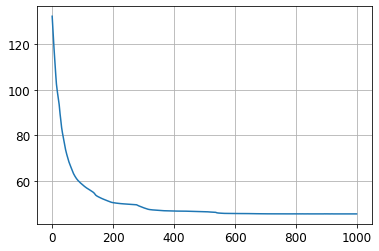

In [116]:
latent_values = optimize_coding(real_coding, weight_pca)
print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight_pca).numpy())
print(latent_values)

(8, 24)


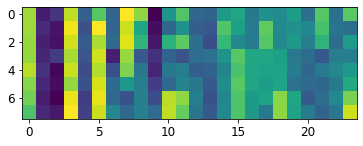

In [131]:
gen_output_1 = generator(latent_values, training=False)[:,:(ntimes - 1),:,:][0,:,:24,0]
print(gen_output_1.shape)
plt.imshow(gen_output_1)

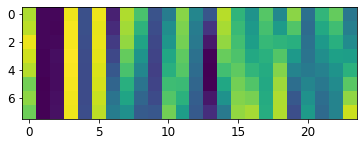

In [136]:
#plt.imshow(real_coding.reshape((8,-1)))
real_dat = np.reshape(real_coding, (8,243))
real_dat = real1[:, :24]
plt.imshow(real_dat)

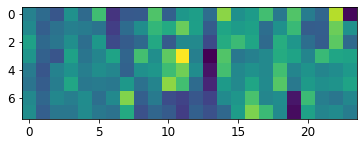

In [139]:
diff = real_dat - gen_output_1
plt.imshow(diff)
#print(diff)